In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score

from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

!cp ../input/mia-v2 mia_v2 -r

from mia_v2.shadow_models import *
from mia_v2.attack_model import *
from mia_v2.utilities import *
from mia_v2.wrappers import *
from mia_v2.categorical_perturbator import augment_categorical_dataset

Num GPUs Available:  0


In [2]:
def f_target():
    model = models.Sequential([
            layers.Dense(128, activation='tanh'),
            layers.Dense(N_CLASSES)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [3]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1e-3, patience=10)
epochs = 200
batch_size = 64

In [4]:
N_SHADOWS = 5
D_SHADOW_SIZE = 17000

In [5]:
def f_attack():
    model = models.Sequential(
        [
            layers.Dense(N_CLASSES+1),
            layers.LeakyReLU(0.3),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def attack_purchase_k(k):
    global N_CLASSES
    N_CLASSES=k
    print(f'Attacking on Purchase-{k}')
    # get dataset
    dataset_path = f'../input/purchase-datasets/purchase-{k}.csv' 
    data_df = pd.read_csv(dataset_path, index_col=0)
    y = data_df.pop('label').to_numpy(dtype=np.int8).reshape(-1)
    X = data_df.to_numpy(dtype=np.int8) 
    
    # divide to target and attack dataset
    X_target, X_attacker, y_target, y_attacker = train_test_split(X, y, train_size=14926, test_size=3*10**4, shuffle=True, random_state=0)
    # train-test split for the target
    X_train, X_test, y_train, y_test = train_test_split(X_target, y_target, test_size=0.33, shuffle=True, random_state=0)
    print(f'D_train_in size: {X_train.shape[0]}. Ready to train target model...')
    
    target_model = f_target()
    history = target_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[es])
    print(f'Label_only: Attacking with {X_attacker.shape[0]} datapoints...')
    attack = LabelOnlyAttack(target_model, 
                                        (X_train, y_train), 
                                        (X_attacker, y_attacker), 
                                        attack_model_creator=f_attack,
                                        shadow_creator=f_target, 
                                        n_shadows=N_SHADOWS, 
                                        D_shadow_size=D_SHADOW_SIZE, 
                                        verbose=False)
    attack.perform_attack(
        augmentation_generator=augment_categorical_dataset, 
        aug_gen_args={'n_perturbations':20, 'max_dist':2, 'sampling':True}, 
        shadow={'epochs':epochs, 'batch_size':128, 'callbacks':[es]}, 
        attack={'epochs':50, 'batch_size':128})
    res = attack.evaluate_attack()
    
    del data_df
    return res

In [7]:
N_CLASSES_LIST = [5, 10, 20, 50, 100]

Attacking on Purchase-5
D_train_in size: 10000. Ready to train target model...


2022-03-16 10:48:05.115501: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-16 10:48:05.263580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
157/157 [==============================] - 1s 5ms/step - loss: 0.6525 - accuracy: 0.7489 - val_loss: 0.4477 - val_accuracy: 0.8283
Epoch 2/200
157/157 [==============================] - 1s 4ms/step - loss: 0.3473 - accuracy: 0.8692 - val_loss: 0.3583 - val_accuracy: 0.8565
Epoch 3/200
157/157 [==============================] - 1s 4ms/step - loss: 0.2574 - accuracy: 0.9101 - val_loss: 0.3373 - val_accuracy: 0.8542
Epoch 4/200
157/157 [==============================] - 1s 4ms/step - loss: 0.2090 - accuracy: 0.9275 - val_loss: 0.3004 - val_accuracy: 0.8745
Epoch 5/200
157/157 [==============================] - 1s 4ms/step - loss: 0.1703 - accuracy: 0.9447 - val_loss: 0.2934 - val_accuracy: 0.8778
Epoch 6/200
157/157 [==============================] - 1s 4ms/step - loss: 0.1528 - accuracy: 0.9513 - val_loss: 0.3178 - val_accuracy: 0.8691
Epoch 7/200
157/157 [==============================] - 1s 5ms/step - loss: 0.1253 - accuracy: 0.9624 - val_loss: 0.2956 - val_accuracy: 0.8784

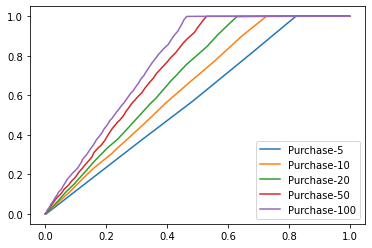

In [8]:
pre, rec, acc, auc = [], [], [], [] 
for k in N_CLASSES_LIST:
    _res, _auc, _fpr, _tpr = attack_purchase_k(k)
    pre.append(_res['macro avg']['precision'])
    rec.append(_res['macro avg']['recall'])
    acc.append(_res['accuracy'])
    auc.append(_auc)
plt.legend([f'Purchase-{k}' for k in N_CLASSES_LIST])

([<matplotlib.axis.XTick at 0x7f18acfdf490>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

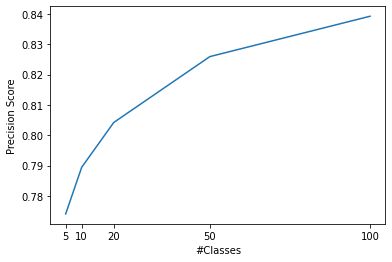

In [9]:
plt.plot(N_CLASSES_LIST, pre)
plt.xlabel('#Classes')
plt.ylabel('Precision Score')
plt.xticks(N_CLASSES_LIST)

([<matplotlib.axis.XTick at 0x7f18539758d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

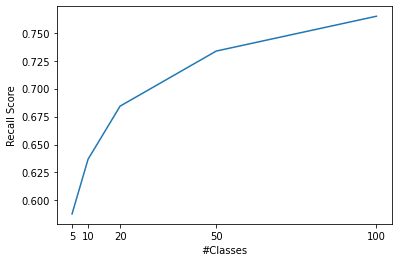

In [10]:
plt.plot(N_CLASSES_LIST, rec)
plt.xlabel('#Classes')
plt.ylabel('Recall Score')
plt.xticks(N_CLASSES_LIST)

([<matplotlib.axis.XTick at 0x7f18d022bed0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

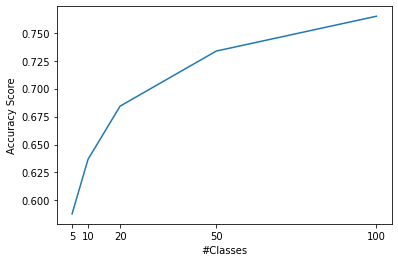

In [11]:
plt.plot(N_CLASSES_LIST, acc)
plt.xlabel('#Classes')
plt.ylabel('Accuracy Score')
plt.xticks(N_CLASSES_LIST)

([<matplotlib.axis.XTick at 0x7f1853365cd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

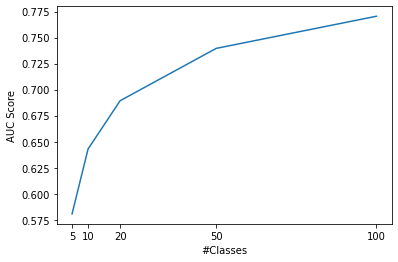

In [12]:
plt.plot(N_CLASSES_LIST, auc)
plt.xlabel('#Classes')
plt.ylabel('AUC Score')
plt.xticks(N_CLASSES_LIST)